In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import os
import math
import json
# gmaps and geojson
import geopy.distance
import gmaps
import gmaps.geojson_geometries

# Google developer API key
from config import gkey
gmaps.configure(api_key=gkey)

# List of Eight World Cities Chosen
cityL=["Amsterdam","Beijing","Las Vegas","Los Angeles","Madrid","New York","Paris","Sydney"]

# file to save geocodes for each city
geo_data_file = os.path.join("Resources","geocodes.csv")

In [3]:
# Get location and bounding box latitude and longitude for each city using Google geocode
base_url = "https://maps.googleapis.com/maps/api/geocode/json?"

geobounds=[]
params={
    "key": gkey
}
for city in cityL:
    params["address"] = city
    response = requests.get(base_url, params=params)
    geo_data = response.json()
    cdict={"city":city}
    cdict["lat"] = geo_data["results"][0]["geometry"]["location"]["lat"]
    cdict["lng"] = geo_data["results"][0]["geometry"]["location"]["lng"]
    cdict["lat1"] = geo_data["results"][0]["geometry"]["bounds"]["northeast"]["lat"]
    cdict["lng1"] = geo_data["results"][0]["geometry"]["bounds"]["northeast"]["lng"]
    cdict["lat2"] = geo_data["results"][0]["geometry"]["bounds"]["southwest"]["lat"]
    cdict["lng2"] = geo_data["results"][0]["geometry"]["bounds"]["southwest"]["lng"]
    geobounds.append(cdict)

geodf = pd.DataFrame(geobounds)

# save geography coords
geodf.to_csv(geo_data_file, index = False)

geodf

,city,lat,lat1,lat2,lng,lng1,lng2
0,Amsterdam,52.367984,52.431157,52.278139,4.903561,5.068390,4.728856
1,Beijing,39.904200,41.060816,39.442758,116.407396,117.514625,115.423411
2,Las Vegas,36.169941,36.380623,36.129623,-115.139830,-115.062072,-115.414625
3,Los Angeles,34.052234,34.337306,33.703652,-118.243685,-118.155289,-118.668176
4,Madrid,40.416775,40.563845,40.312064,-3.703790,-3.524911,-3.834162
5,New York,40.712775,40.917577,40.477399,-74.005973,-73.700272,-74.259090
6,Paris,48.856614,48.902145,48.815573,2.352222,2.469921,2.224199
7,Sydney,-33.868820,-33.578141,-34.118347,151.209295,151.343021,150.520929


In [4]:
# retrieve geography coords without re-running cell above
geodf = pd.read_csv(geo_data_file, index_col = "city")
geodf

,lat,lat1,lat2,lng,lng1,lng2
city,,,,,,
Amsterdam,52.367984,52.431157,52.278139,4.903561,5.068390,4.728856
Beijing,39.904200,41.060816,39.442758,116.407396,117.514625,115.423411
Las Vegas,36.169941,36.380623,36.129623,-115.139830,-115.062072,-115.414625
Los Angeles,34.052234,34.337306,33.703652,-118.243685,-118.155289,-118.668176
Madrid,40.416775,40.563845,40.312064,-3.703790,-3.524911,-3.834162
New York,40.712775,40.917577,40.477399,-74.005973,-73.700272,-74.259090
Paris,48.856614,48.902145,48.815573,2.352222,2.469921,2.224199
Sydney,-33.868820,-33.578141,-34.118347,151.209295,151.343021,150.520929


In [6]:
# retrieve Airbnb info saved in folders with city names, merge into one dataframe

# function for returning distance to point center for row with latitude and longitude in df
def get_distance (row, center):
    start = (row['latitude'], row['longitude'])
    return geopy.distance.distance(start, center).km

dfexists = False

for city in cityL:
    path = os.path.join(city,"listings 2.csv")
    #print(path)
    citydf = pd.read_csv(path)
    citydf["key"]=city
    # make sure this only includes locations within city bounding box
    coords = geodf.loc[city]
    citydf = citydf.loc[(citydf["latitude"]<=coords["lat1"]) & (citydf["latitude"]>=coords["lat2"])
                 &(citydf["longitude"]<=coords["lng1"]) & (citydf["longitude"]>=coords["lng2"])]
    # add a new column, distance to center
    center = (coords["lat"],coords["lng"])
    citydf["center_distance"] = citydf.apply (lambda row: get_distance(row, center),axis=1)
    if dfexists:
        allcitydf = pd.concat([allcitydf, citydf], ignore_index=True)
    else:
        allcitydf = citydf
        dfexists = True


allcitydf.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,key,center_distance
0,2818,https://www.airbnb.com/rooms/2818,20190307044014,2019-03-07,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",...,strict_14_with_grace_period,f,f,1,0,1,0,2.07,Amsterdam,2.590703
1,20168,https://www.airbnb.com/rooms/20168,20190307044014,2019-03-07,100%Centre-Studio 1 Private Floor/Bathroom,"Cozy studio on your own private floor, 100% in...",For those who like all facets of city life. In...,"Cozy studio on your own private floor, 100% in...",none,Located just in between famous central canals....,...,strict_14_with_grace_period,f,f,2,1,1,0,2.29,Amsterdam,0.754776
2,25428,https://www.airbnb.com/rooms/25428,20190307044014,2019-03-07,Lovely apt in City Centre (Jordaan),NaN,"This nicely furnished, newly renovated apt is...","This nicely furnished, newly renovated apt is...",none,NaN,...,strict_14_with_grace_period,f,f,2,2,0,0,0.15,Amsterdam,1.469958
3,27886,https://www.airbnb.com/rooms/27886,20190307044014,2019-03-07,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,For a romantic couple: A beautifully restored ...,Stylish and romantic houseboat on fantastic hi...,none,"Central, quiet, safe, clean and beautiful.",...,strict_14_with_grace_period,f,f,1,0,1,0,2.07,Amsterdam,2.227640
4,28658,https://www.airbnb.com/rooms/28658,20190307044014,2019-03-07,Cosy guest room near city centre -1,2 beds guest room in Amsterdam West near Erasm...,Cosy small but comfortable guest room with twi...,2 beds guest room in Amsterdam West near Erasm...,none,"The listing is located in Amsterdam west, betw...",...,moderate,t,t,2,0,2,0,4.14,Amsterdam,3.256001


In [7]:
# get approx city bounding box size for metro size area comparison, approx listing density
sizeL = []

for city in cityL:
    cdict={"city":city}
    coords = geodf.loc[city]
    width = geopy.distance.distance((coords['lat1'],coords['lng1']),(coords['lat2'],coords['lng1'])).km
    height = geopy.distance.distance((coords['lat1'],coords['lng1']),(coords['lat1'],coords['lng2'])).km
    cdict["width"]=width
    cdict["height"]=height
    cdict["area"] = width * height
    cdict["listing_count"] = allcitydf.loc[allcitydf["key"]==city]['id'].count()
    cdict["list/sq_km"] = cdict["listing_count"]/cdict["area"]
    sizeL.append(cdict)
    
boundsizedf = pd.DataFrame(sizeL).set_index("city")
boundsizedf

,area,height,list/sq_km,listing_count,width
city,,,,,
Amsterdam,393.218475,23.093845,49.478855,19456,17.026982
Beijing,31581.847155,175.778629,0.820756,25921,179.668299
Las Vegas,881.067578,31.634010,2.198469,1937,27.851909
Los Angeles,3317.164091,47.194780,11.224347,37233,70.286673
Madrid,732.221512,26.189575,24.107459,17652,27.958511
New York,2301.053447,47.074680,21.619663,49748,48.880916
Paris,173.438539,18.015094,334.723761,58054,9.627402
Sydney,4573.173991,76.322001,7.852096,35909,59.919472


In [70]:
# list cols in db
list(allcitydf)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


In [8]:
# allcitydf.dtypes
# convert price to float
if allcitydf["price"].dtype == 'object':
    allcitydf["price"] = allcitydf["price"].str.replace('$', '')
    allcitydf["price"] = allcitydf["price"].str.replace(',', '')
    allcitydf["price"] = allcitydf["price"].astype(float)

allcitydf["price"].describe()

# drop listings with price = 0
allcitydf = allcitydf.loc[allcitydf['price']!=0]
allcitydf["price"].describe()

count    245864.000000
mean        200.145519
std         597.544722
min           6.000000
25%          69.000000
50%         109.000000
75%         199.000000
max       68980.000000
Name: price, dtype: float64

In [9]:
# dataframe with useful categories
catsdf = allcitydf[['id','latitude','longitude','neighbourhood_cleansed','neighbourhood_group_cleansed','room_type','accommodates','price','number_of_reviews','review_scores_rating','key','center_distance']]

catsdf.count()

# drop rows without a 'review_score_rating'
catsdf = catsdf.dropna(subset=['review_scores_rating'])
catsdf.count()

id                              186361
latitude                        186361
longitude                       186361
neighbourhood_cleansed          186361
neighbourhood_group_cleansed     52372
room_type                       186361
accommodates                    186361
price                           186361
number_of_reviews               186361
review_scores_rating            186361
key                             186361
center_distance                 186361
dtype: int64

In [10]:
# filter type of accommodation/ any trend with number of people accommodated?

filterdf = catsdf.loc[allcitydf['room_type']=='Private room']

# get average ratings/price for private rooms according to amount accommodated
fmeandf = filterdf.groupby(["key","accommodates"])[['price','review_scores_rating']].mean()
fmeandf = fmeandf.reset_index()

# reformatting
guestL = fmeandf["accommodates"].unique()
reformatdf = pd.DataFrame({"accommodates":guestL})

for city in cityL:
    addf= fmeandf.loc[fmeandf["key"]==city][["accommodates",'price','review_scores_rating']].rename(columns = {'review_scores_rating':city+' rating', 'price':city+' price'})
    reformatdf = pd.merge(reformatdf,addf, on="accommodates")

reformatdf = reformatdf.set_index('accommodates')
reformatdf

,Amsterdam price,Amsterdam rating,Beijing price,Beijing rating,Las Vegas price,Las Vegas rating,Los Angeles price,Los Angeles rating,Madrid price,Madrid rating,New York price,New York rating,Paris price,Paris rating,Sydney price,Sydney rating
accommodates,,,,,,,,,,,,,,,,
1,71.018116,93.967391,234.771727,95.747393,42.779221,95.272727,74.307289,95.144023,27.965795,93.642522,69.694732,93.757056,67.658095,93.726667,63.306577,93.294314
2,91.717257,94.087442,268.192351,95.677054,53.801802,95.513514,77.280602,94.925674,44.315872,92.790469,81.678251,93.548399,79.656938,93.150172,83.599932,93.186256
3,103.929293,93.520202,316.625616,95.320197,47.680851,94.808511,79.419355,93.791935,43.849246,90.236181,81.496063,91.903762,112.701754,91.697368,87.899687,90.601881
4,158.773067,94.044888,539.026718,94.568702,69.163636,93.709091,93.357407,93.209259,51.408000,92.080000,110.144890,92.115136,140.772926,92.449782,125.743590,91.816239
5,128.000000,87.600000,598.750000,95.142857,66.875000,95.875000,125.780000,93.940000,58.315789,86.157895,140.098039,91.421569,146.340909,88.340909,130.228571,92.200000
6,222.142857,89.214286,1094.500000,93.800000,145.000000,97.444444,137.340000,94.240000,887.833333,89.083333,217.246914,92.012346,229.516129,90.483871,164.480000,92.240000
7,264.400000,94.800000,793.000000,91.800000,53.000000,97.000000,104.750000,84.250000,102.500000,100.000000,134.187500,85.625000,277.000000,93.200000,171.000000,82.500000
8,127.500000,88.000000,1457.500000,87.818182,340.000000,98.250000,252.214286,87.714286,110.000000,89.666667,152.272727,85.545455,299.666667,90.666667,174.909091,89.909091


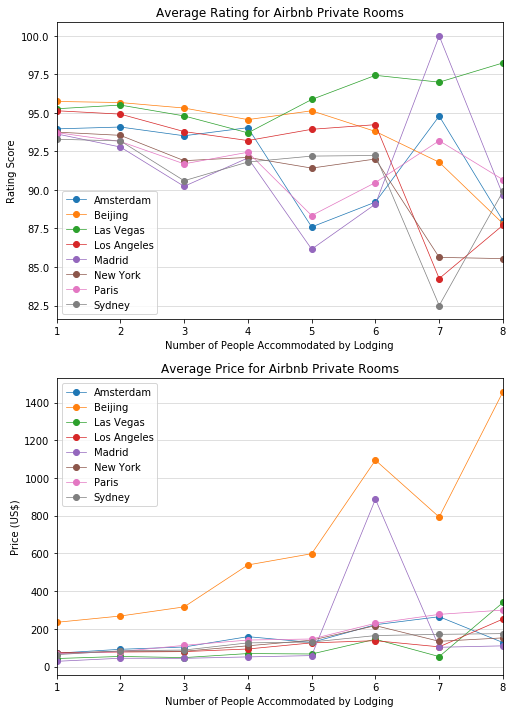

In [177]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,12))

for city in cityL:
    reformatdf[city+' rating'].plot(ax=ax1, marker = "o", linewidth = .7, label=city)
ax1.yaxis.set_label_text("Rating Score")
ax1.xaxis.set_label_text("Number of People Accommodated by Lodging")
ax1.set_title("Average Rating for Airbnb Private Rooms")
ax1.grid(axis='y',alpha = .5)
ax1.legend()

for city in cityL:
    reformatdf[city+' price'].plot(ax=ax2, marker = "o", linewidth = .7, label=city)
ax2.set_title("Average Price for Airbnb Private Rooms")
ax2.xaxis.set_label_text("Number of People Accommodated by Lodging")
ax2.yaxis.set_label_text("Price (US$)")
ax2.grid(axis='y',alpha = .5)
ax2.legend()

#plt.subplots_adjust(hspace=.8)
fig.show()

In [11]:
# filter for only double occupancy to compare to hotel
doubledf = filterdf.loc[filterdf["accommodates"]==2]

meandf = doubledf.groupby(["key"])[['price','review_scores_rating']].mean()
meandf


,price,review_scores_rating
key,,
Amsterdam,91.717257,94.087442
Beijing,268.192351,95.677054
Las Vegas,53.801802,95.513514
Los Angeles,77.280602,94.925674
Madrid,44.315872,92.790469
New York,81.678251,93.548399
Paris,79.656938,93.150172
Sydney,83.599932,93.186256


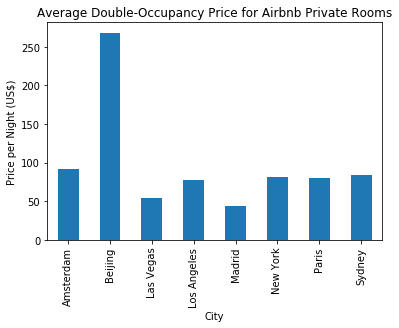

In [179]:
# bar plot mean price comparison for each city
meandf["price"].plot(kind='bar')
plt.xlabel("City")
plt.ylabel("Price per Night (US$)")
plt.title ("Average Double-Occupancy Price for Airbnb Private Rooms")
plt.show()

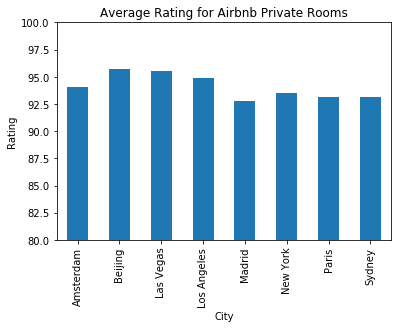

In [180]:
# bar plot rating comparison for double-occupancy private room each city
meandf["review_scores_rating"].plot(kind='bar')
plt.xlabel("City")
plt.ylabel("Rating")
plt.title ("Average Rating for Airbnb Private Rooms")
plt.ylim(80,100)
plt.show()

In [95]:
# Plot Heatmap of New York Listings with Intensity by Price

newyorkdf=doubledf.loc[doubledf["key"]=="New York"]
locations = newyorkdf[["latitude", "longitude"]]
pricing = newyorkdf["price"]

coords = geodf.loc["New York"]
cen = (coords["lat"],coords["lng"])
fig = gmaps.figure(map_type='HYBRID', center=cen, zoom_level=11)
heatmap_layer = gmaps.heatmap_layer(locations, weights=pricing,
                                    max_intensity=400, point_radius=3.0)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [96]:
# Heatmap with intensity by rating
rating = newyorkdf["review_scores_rating"]

coords = geodf.loc["New York"]
cen = (coords["lat"],coords["lng"])
fig = gmaps.figure(map_type='HYBRID', center=cen, zoom_level=11)
heatmap_layer = gmaps.heatmap_layer(locations, weights=rating,
                                    max_intensity=400, point_radius=3.0)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [100]:
# Chloropleth of Neighborhoods, color according to Average Price double occupancy room on Airbnb

city = "New York"
cgeopath=os.path.join(city,"neighbourhoods.geojson")

with open(cgeopath,encoding='utf-8', errors='ignore') as json_data:
     neigh = json.load(json_data, strict=False)


gnewyork = newyorkdf.groupby("neighbourhood_cleansed")[['price','review_scores_rating']].mean()
pmax = gnewyork['price'].max()
pmin = gnewyork['price'].min()

features= neigh['features']
colors= []
centroids=[]
labels = []

for hood in features:
    nname = hood["properties"]["neighbourhood"]
    coords = hood["geometry"]["coordinates"][0][0]
    centroid = np.asarray(coords).mean(axis=0)
    loc=(centroid[1], centroid[0])
    centroids.append(loc)
    
    try:
        p = gnewyork.loc[nname]['price']
        c = int(255 * p/pmax)
        color = (c,255-c,255-c, 1)
    except (KeyError, ValueError) as e:
        color = (255, 255, 255, 0.0)
    colors.append(color)
    labels.append(nname+": $"+str(int(p)))

#colors
symbol_layer = gmaps.symbol_layer(centroids, info_box_content=labels, fill_color=(0,0,0,.7), stroke_color=colors, stroke_opacity=.7, scale=2)

coords = geodf.loc["New York"]
cen = (coords["lat"],coords["lng"])
fig = gmaps.figure(center=cen, zoom_level=10)

nlay = gmaps.geojson_layer(neigh,fill_color=colors,stroke_color='white', fill_opacity=.8)
fig.add_layer(nlay)
fig.add_layer(symbol_layer)
fig


Figure(layout=FigureLayout(height='420px'))